In [39]:
import pandas as pd

# load die CSV-Datei
data = pd.read_csv('../raw_data/WELFake_Dataset.csv')

In [40]:
print(f"data.shape: {data.shape}")

data.shape: (72134, 4)


In [41]:
data = data.head(55000)

In [24]:
data['text'] = data['text'].astype('string')
data['title'] = data['title'].astype('string')
data['label'] = data['label'].astype('bool')

# Check Data

## combine title and text, and delete title

In [42]:
data.drop('Unnamed: 0',axis=1,inplace=True)

In [43]:
## Cleaning 2: combine the text and the title
## Cleaning 1: filling the missing data with spaces 
data = data.fillna(' ') ## aplying to na via fillna

## Cleaning 2: combine the text and the title
data['text'] = data['title'] + data['text']

## delete title column
data.drop('title',axis=1,inplace=True)

In [44]:
print(f"data.shape: {data.shape}")

data.shape: (55000, 2)


In [28]:
# Calculation of the distribution in per cent
label_counts = data['label'].value_counts(normalize=True) * 100
# Formatted output
print(f"Balancing result is label 0: {label_counts.get(0, 0):.2f}%, label 1: {label_counts.get(1, 0):.2f}%")

Balancing result is label 0: 51.44%, label 1: 48.56%


/tmp/ipykernel_47155/4147717439.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Balancing result is label 0: {label_counts.get(0, 0):.2f}%, label 1: {label_counts.get(1, 0):.2f}%")


## check balance

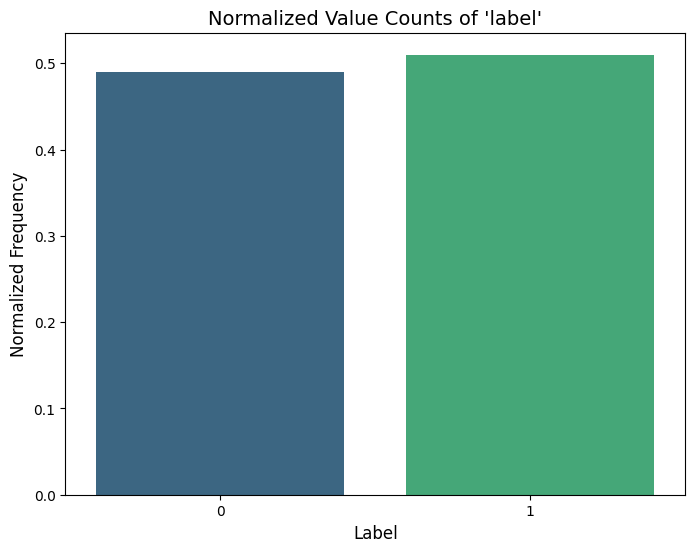

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the normalised values
label_counts = round(data["label"].value_counts(normalize=True), 2)

# Create the plot
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette="viridis", legend=False)

# Add title and axis identifier
plt.title("Normalized Value Counts of 'label'", fontsize=14)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Normalized Frequency", fontsize=12)

# Show the plot
plt.show()

## check nulls

In [55]:
# Calculate percentage of NaN values in each column
nan_percentage = (data.isna().sum() / len(data)) * 100

# Format output with percentage symbol
formatted_nan_percentage = nan_percentage.apply(lambda x: f"{x:.2f}%")

# Print each column's NaN percentage
for col, percentage in formatted_nan_percentage.items():
    print(f"{col}: {percentage}")

text: 0.00%
label: 0.00%


In [56]:
data.shape

(55000, 2)

## delete duplicated raws

In [11]:
data.drop_duplicates(inplace=True)

# Baseline


## Data cleaning: strip, lower, digit, punctuation

In [12]:
import re
import string
    
def basic_cleaning(texte):
    # stripping:
    data['text'] = data['text'].str.strip()

    # tolower:
    data['text'] = data['text'].str.lower()
    
    # digit: Remove digits from each row of the ‘text’ column
    data['text'] = data['text'].apply(lambda x: ''.join(char for char in x if not char.isdigit()))
        
    # punctuation: Remove all punctuation marks from the ‘text’ column
    data['text'] = data['text'].str.replace(r'[{}]'.format(re.escape(string.punctuation)), '', regex=True)
    
    # delete html-tags    
    data['text'] = data['text'].apply(lambda x: re.sub('<[^<]+?>', '', x))

    return data['text']

In [13]:
import time
s = time.time()
data['text'] = basic_cleaning(data['text'])
time_to_clean = time.time() - s
print('Time to basic clean {:.2f} s'.format(time_to_clean))

Time to basic clean 24.20 s


In [14]:
data.head()

,text,label
0,law enforcement on high alert following threat...,True
1,did they post their votes for hillary already,True
2,unbelievable obama’s attorney general says mos...,True
3,bobby jindal raised hindu uses story of christ...,False
4,satan russia unvelis an image of its terrifyi...,True


##  Naive Bayes model (MultinomialNB)

In [15]:
# Shuffle the dataframe
data = data.sample(frac=1,random_state=42)

In [57]:
X = data['text']
y = data['label']
X.info()

<class 'pandas.core.series.Series'>
RangeIndex: 55000 entries, 0 to 54999
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
55000 non-null  object
dtypes: object(1)
memory usage: 429.8+ KB


In [17]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

# Create tokenization and modelling pipeline
# MultinomialNB: Naive Bayes is a probabilistic classification model based on Bayes' theorem. 
# It is particularly effective for text classification tasks
model_NB = Pipeline([
                    ("tfidf",TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf",MultinomialNB())])    # model the text

# Fit the pipeline to the training data
model_NB.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [18]:
test_score = model_NB.score(X_test,y_test) # calculates the accuracy of the model on the test set
test_score

0.8335109926715523

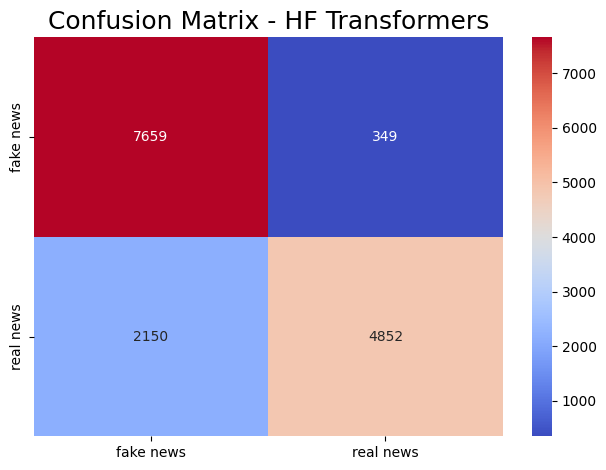

In [19]:
y_pred = model_NB.predict(X_test)

# Generate array of values for confusion matrix
cm = confusion_matrix(y_test,y_pred)

ax = sns.heatmap(cm, annot=True, cmap="coolwarm", fmt="d", cbar=True)
ax.xaxis.set_ticklabels(['fake news','real news']) 
ax.yaxis.set_ticklabels(['fake news','real news'])
ax.set_title('Confusion Matrix - HF Transformers',fontsize=18)

plt.tight_layout()

In [20]:
X_test.shape

(15010,)

## Analysis

Analysis:
	- The model correctly recognised 10090 ‘fake news’ items and correctly classified 5567 ‘real news’ items.
	- However, it made 311 errors by classifying ‘fake news’ as ‘real news’.
	- 3136 ‘real news’ was incorrectly classified as ‘fake news’.

Interpretation:

The high number of false positives (311) indicates that the model has difficulty reliably distinguishing ‘fake news’ from ‘real news’. in this case the model could be improved by:
	- Optimising hyperparameters.
	- Trying out other feature engineering techniques or model architectures.

# Alternative model

## Data cleaning: tokenizing, stopwords, lemmatize

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import time
#import nltk

#nltk.download('punkt_tab')
#nltk.download('punkt')
#nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Tokenise and remove stop words
def delete_stop_words(text):
    return [word for word in text if word.lower() not in stop_words and word not in string.punctuation]

# apply Lemmatization-Funktion
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    # Verben lemmatisieren
    verb_lemmatized = [lemmatizer.lemmatize(word, pos="v") for word in text]
    # Nomen lemmatisieren
    return [lemmatizer.lemmatize(word, pos="n") for word in verb_lemmatized]

# NLP-Cleaningfunktion
def nlp_cleaning(texte):
    # Tokenisation
    texte = texte.apply(word_tokenize)
    # Remove stop words
    texte = texte.apply(delete_stop_words)
    # Lemmatisation
    texte = texte.apply(lemmatize_text)
    # Combine words into a string
    return texte.apply(lambda x: ' '.join(x))

# start cleaning for nlp
s = time.time()
data['text'] = nlp_cleaning(data['text'])
print(f"Time to nlp clean: {time.time() - s:.2f} seconds")


In [ ]:
data.head(10)

## RNN Model (Recurrent Neural Networks)

In [ ]:
# please implement me

### Analysis

## LSTM (Long Short-Term Memory Networks)

In [ ]:
# please implement me

### Analysis